In [1]:
!wget -nc https://www.dropbox.com/s/lkd0eklmi64m9xm/AirlineTweets.csv?dl=0

File ‘AirlineTweets.csv?dl=0’ already there; not retrieving.



In [2]:

!pip install transformers[torch] accelerate -U
!pip install torch-xla
import transformers
import accelerate
import torch
print("Transformers version:", transformers.__version__)
print("Accelerate version:", accelerate.__version__)
print("PyTorch version:", torch.__version__)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Transformers version: 4.39.3
Accelerate version: 0.29.2
PyTorch version: 2.2.1+cu121


In [3]:
import pandas as pd
import numpy as np

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('AirlineTweets.csv?dl=0')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [7]:
df = df[['airline_sentiment','text']]

In [8]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<Axes: >

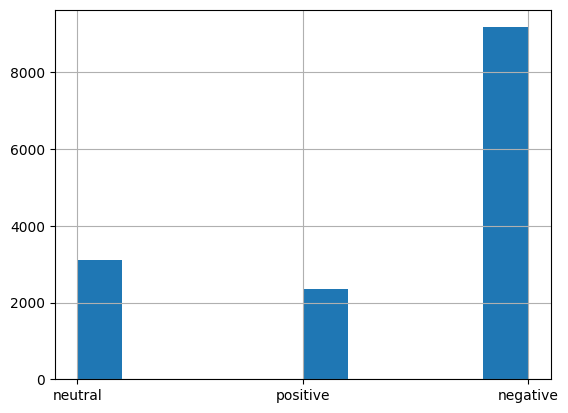

In [9]:
df['airline_sentiment'].hist()

In [10]:
target_map = { 'positive': 1, 'negative': 0, 'neutral': 2}
df['target'] = df['airline_sentiment'].map(target_map)

In [11]:
df1 = df[['text','target']]
df1.columns = ['sentence','label']
df1.to_csv('data.csv', index = False)

In [12]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00


In [13]:
from datasets import load_dataset
raw_dataset = load_dataset('csv', data_files = 'data.csv')

Generating train split: 0 examples [00:00, ? examples/s]

In [14]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [15]:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)

In [16]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [17]:
# Import AutoTokenizer and create tokenizer object
from transformers import AutoTokenizer
checkpoint = 'bert-base-cased'
tokernizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [18]:
def tokenize_fn(batch):
  return tokernizer(batch['sentence'], truncation = True)

In [19]:
tokenized_dataset = split.map(tokenize_fn, batched = True)

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

In [20]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

In [21]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 3)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
!pip install torchinfo

In [23]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           2,307
Total params: 10

In [24]:
training_args = TrainingArguments(output_dir='/content/drive/My Drive/GFU-ChatGPTtrans/Kurs-2/training_dir',
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=3,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=64,
                                  )

In [25]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average = 'micro')
  return {'accuracy': acc, 'f1_score': f1}

In [26]:
trainer = Trainer(model,
                  training_args,
                  train_dataset = tokenized_dataset["train"],
                  eval_dataset = tokenized_dataset["test"],
                  tokenizer=tokernizer,
                  compute_metrics=compute_metrics)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss


In [ ]:
! ls /content/drive/My Drive/GFU-ChatGPTtrans/Kurs-2/training_dir

In [ ]:
from transformers import pipeline

In [ ]:
saved_model = pipeline('text-classification',
                       model = '/content/drive/My Drive/GFU-ChatGPTtrans/Kurs-2/training_dir/checkpoint-1282')

In [ ]:
split['test']

In [ ]:
prediction = saved_model(split['test']['sentence'])

In [ ]:
prediction[:10]

In [ ]:
def get_label(d):
  return int(d['label'].split('_')[1])
predictions = [get_label(d) for d in prediction]

In [ ]:
print("acc:",accuracy_score(split['test']['label'], predictions))

In [ ]:
print("f1:",f1_score(split['test']['label'], predictions, average = 'macro'))

In [ ]:
import seaborn as sns

In [ ]:
# create function for plotting confusion matrix
def plot_cm(cm):
  classes = ['negative','positive','neutral']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sns.heatmap(df_cm, annot = True, fmt='g')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

cm = confusion_matrix(split['test']['label'],predictions, normalize = 'true')
plot_cm(cm)